In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Anomalies:**
Something that deviates from what is standard, normal, or expected.[Oxford]

Import Libraries

In [27]:
import matplotlib.pyplot as plt
import torch
#print(torch.__version__)
from torch import nn
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid



Data Preparation

In [31]:
def show_data(sample, infos):
    image, label = sample
    plt.imshow(image)
    plt.title('Label = '+ str(label))
    plt.show()
    if infos == True:
        width, height = image.size
        print(f"Size of {width} x {height} ")

dataset = datasets.ImageFolder('/content/drive/MyDrive/Colab Notebooks/Extend AI/Dataset-Pytorch')


Data Augmentation


In [39]:
torch.manual_seed(2)

# To resize images
width_target=128
height_target=128
image_transforms = [
transforms.Compose([transforms.Resize((height_target, width_target)),transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
transforms.Compose([transforms.Resize((height_target, width_target)),transforms.ColorJitter(brightness=0, contrast=0.5, saturation=0, hue=0), transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
transforms.Compose([transforms.Resize((height_target, width_target)),transforms.RandomHorizontalFlip(1.0), transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
transforms.Compose([transforms.Resize((height_target, width_target)),transforms.RandomVerticalFlip(1.0), transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
transforms.Compose([transforms.Resize((height_target, width_target)),transforms.GaussianBlur(kernel_size=(3,3)), transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
transforms.Compose([transforms.Resize((height_target, width_target)),transforms.RandomAffine(45), transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
]

# Data augmentation
list_data = []
for transform in image_transforms:
    dataset = datasets.ImageFolder('/content/drive/MyDrive/Colab Notebooks/Extend AI/Dataset-Pytorch', transform=transform)
    #print(dataset.targets)
    list_data.append(dataset)
    
augmented_set = torch.utils.data.ConcatDataset(list_data)
print(f"Number of images in the augmented dataset is {len(augmented_set)} ")

Number of images in the augmented dataset is 42 


types: <class 'torch.Tensor'> <class 'int'>
shapes: torch.Size([3, 128, 128]) torch.Size([])


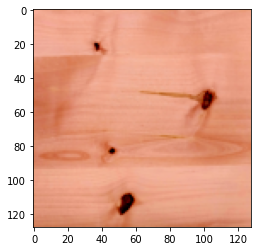

In [40]:
# Visualization

# Sample 
sample = next(iter(augmented_set))
image, label = sample

print('types:', type(image), type(label))
print('shapes:', image.shape, torch.tensor(label).shape)

# Given a Tensor representing the image, use .permute() to put the channels as the last dimension:
plt.imshow(image.permute(1, 2, 0))

# Additional notes: To remove the 1 in the dimension of the image mais ici c'est 3 alors t'es con
#print(image.squeeze().shape)
# Source https://deeplizard.com/learn/video/mUueSPmcOBc


Creating dataset for Normal and Anomalies

In [42]:
Normal=[]
Anomaly = [] 

for i in range(len(augmented_set)):
    if augmented_set[i][1] == 1:
        Anomaly.append(augmented_set[i])
    else:
        Normal.append(augmented_set[i])

print(' Normal dataset =' + str(len((Normal))) + ' elements')
print(' Anomaly dataset = ' + str(len((Anomaly))) + ' elements')  

 Normal dataset =18 elements
 Anomaly dataset = 24 elements


Train_Test split 

In [43]:
num_anomalies = 7
num_normal = 7

# Random_split returns two datasets
train_set , test_normal = torch.utils.data.random_split(Normal, [len(Normal)-num_normal, num_normal], generator=torch.Generator().manual_seed(42))
_ , test_anomaly = torch.utils.data.random_split(Anomaly, [len(Anomaly)-num_anomalies, num_anomalies], generator=torch.Generator().manual_seed(42)) 

# Add anomaly to test_set
test_set = torch.utils.data.ConcatDataset([test_anomaly,test_normal])

print(' Test dataset has now ' + str(len((test_set))) + ' elements, composed of ' + str(num_normal) + '  normal  data and ' + str((num_anomalies)) + ' anomalies')

 Test dataset has now 14 elements, composed of 7  normal  data and 7 anomalies


In [44]:
batch_size=1

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)

print(' The train loader has ' + str(len((train_loader))) + ' elements')
print(' The test loader has ' + str(len((test_loader))) + ' elements')

 The train loader has 11 elements
 The test loader has 14 elements


Data Loader visualization

In [45]:
#  Visualize train data

batch_size=5
train_loader5 = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
batch_iter=iter(train_loader5)

Train dataloader visualization 


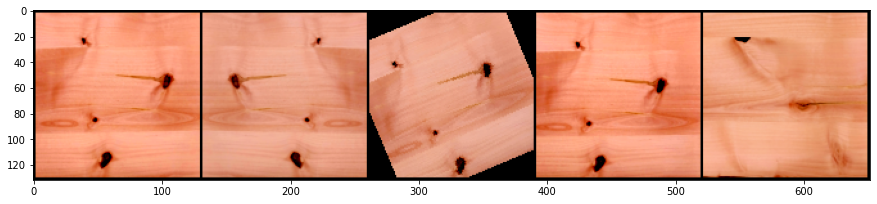

labels: tensor([0, 0, 0, 0, 0])


In [46]:
print('Train dataloader visualization ')

batch = next(batch_iter)
images, labels = batch
# Plot a batch
grid = make_grid(images, nrow=10)
plt.figure(figsize=(15,15))
plt.imshow(grid.permute(1,2,0))   
plt.show()
print('labels:', labels)

In [47]:
#  Visualize test data

batch_size=5
test_loader5 = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)
batch_iter=iter(test_loader5)

Test dataloader visualization 


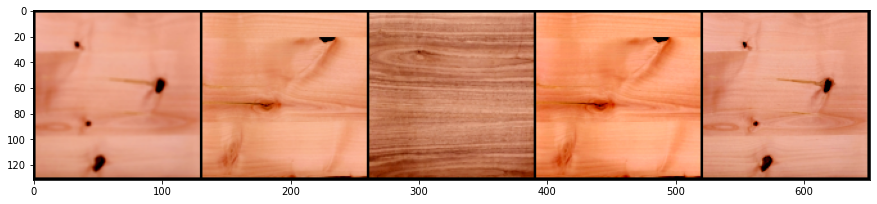

labels: tensor([0, 0, 1, 0, 0])


In [48]:
print('Test dataloader visualization ')

batch = next(batch_iter)
images, labels = batch
# Plot a batch
grid = make_grid(images, nrow=10)
plt.figure(figsize=(15,15))
plt.imshow(grid.permute(1,2,0))   
plt.show()
print('labels:', labels)

**Autoencoder**
The neural network of choice for our anomaly detection application is the Autoencoder. This is due to the autoencoders ability to perform feature extraction as the dimensionality is reduced to build a latent representation of the input distribution. How it can exploit that is by utilizing a loss distribution of rebuilt inputs to outputs (which turns out to be Guassian) and making the assumption that any outliers will be anomalies since they faulter well outside the parameters of what the model considers “within the expected distribution”.

Since autoencoders are typically unsupervised (there are versions that are semi-supervised and there is also work going into supervised versions of this model) meaning that to determine if the model is learning a proper representation of the underlying distribution, the re-built output is compared against the input as a sort of pseudo-label. unsupervised in given dataset.

Autoencoder

In [49]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=15, kernel_size=5, padding=0, stride=2), 
            nn.ReLU(), 
            nn.MaxPool2d(2, 2) 

        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=15, out_channels=3, kernel_size=5, stride=4, output_padding=3),
            nn.ReLU()
        )
    
    def forward(self, x):
        # Encoded
        x = self.encoder(x)
        x = self.decoder(x)
        return x

Train the model and Core training parameters.

I have implemented the MSELoss class as  loss function between output and input.

In [50]:
torch.manual_seed(42)
learning_rate = 1e-3

#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model = Autoencoder().to(device)
model.train()

# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# mean-squared error loss
criterion = nn.MSELoss() 

print(model)

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 15, kernel_size=(5, 5), stride=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(15, 3, kernel_size=(5, 5), stride=(4, 4), output_padding=(3, 3))
    (1): ReLU()
  )
)


In [52]:
epochs = 10
cost=[]

for epoch in range(epochs):
    train_loss = 0
    for data in train_loader:
        images, _ = data
        images = images.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*images.size(0)/len(train_loader)
        
    cost.append(train_loss)
    
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))
        

Epoch: 0 	Training Loss: 0.332509
Epoch: 1 	Training Loss: 0.266495
Epoch: 2 	Training Loss: 0.227145
Epoch: 3 	Training Loss: 0.203439
Epoch: 4 	Training Loss: 0.193961
Epoch: 5 	Training Loss: 0.186893
Epoch: 6 	Training Loss: 0.185756
Epoch: 7 	Training Loss: 0.185096
Epoch: 8 	Training Loss: 0.184720
Epoch: 9 	Training Loss: 0.184376


Output the loss plot to determine if model has converged to a solution.

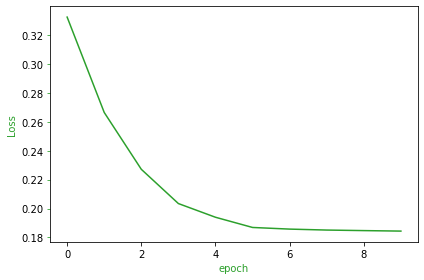

In [54]:
# Visualize convergence

# Plot the loss and accuracy

fig, ax1 = plt.subplots()
color = 'tab:green'
ax1.plot(cost, color=color)
ax1.set_xlabel('epoch', color=color)
ax1.set_ylabel('Loss', color=color)
ax1.tick_params(axis='y', color=color)
    
fig.tight_layout()

From above graph, the Autoencoder has successfully captured the features of the input distribution within its compressed latent representation.

Reconstruction visualization

In [55]:
def show_results(dataset, idx, infos=True):
    model.eval()
    image, label= dataset[idx]
    input_image = image[None, :, :, :]  # Add extra dimension
    output_image = model(input_image.to(device))
    
    input_image = input_image[0].permute(1, 2, 0)
    output_image = output_image[0].cpu().permute(1, 2, 0).detach()
    loss_image = torch.abs(input_image-output_image)
    
    fig = plt.figure(figsize=(7,2))
    ax1 = fig.add_subplot(1,3,1)
    ax1.set_title('Input - Label:' + str(label))
    ax1.imshow(input_image)
    ax2 = fig.add_subplot(1,3,2)
    ax2.set_title('Output')
    ax2.imshow(output_image)
    ax3 = fig.add_subplot(1,3,3)
    ax3.set_title('Difference')
    ax3.imshow(loss_image)
    
    if infos==True:
        print(f"Size of input image is {input_image.size()}")
        print(f"Size of output image is {output_image.size()}")

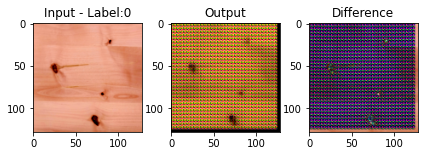

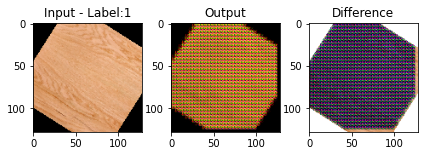

In [56]:
show_results(train_set, 0, infos=False)
show_results(test_set, 0, infos=False)

Prediction

For our model to determine if an input is or is not an anomaly, I have used the loss value from the output and input — if the loss value is high, then I assume that the model is seeing an element that is outside of the known distribution representation. To achieve this, I have iterate through our test set sequentially and retaining the loss value. 

In [57]:
torch.manual_seed(5)
model.eval()
loss_dist = []
label_list=[]

for data in test_loader:
    images, label = data
    images = images.to(device)
    outputs = model(images)
    loss = criterion(outputs, images)
    loss_dist.append(loss.item())
    label_list.append(label.item())

anom_list=[]
normal_list=[]

for i in range(len(label_list)):
    if label_list[i] == 1.0:  # Detected as an anomally
        anom_list.append(loss_dist[i])  
    else:
        normal_list.append(loss_dist[i])  

print(f"Total number of predictions: {len(label_list)}")
print(f"Number of anomalies: {len(anom_list)}")
print(f"Number of normal data: {len(normal_list)}")


Total number of predictions: 14
Number of anomalies: 7
Number of normal data: 7


Results

Visualizing the loss values will give us valuable insight to where our anomalies are hiding. A simple way of doing this is by projecting each value as a point and observing the plot.

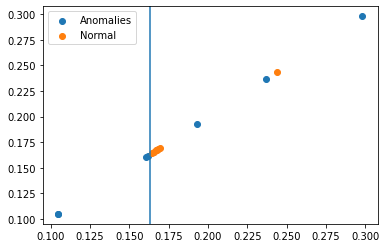

In [74]:
anom_sc = []
normal_sc = []
for i in anom_list:
    anom_sc.append((i,i))
for i in normal_list:
    normal_sc.append((i,i))
plt.scatter(*zip(*anom_sc),label='Anomalies')
plt.scatter(*zip(*normal_sc),label='Normal')
plt.axvline(0.163, 0.0, 1)
plt.legend()

Define here lower and upper threshold


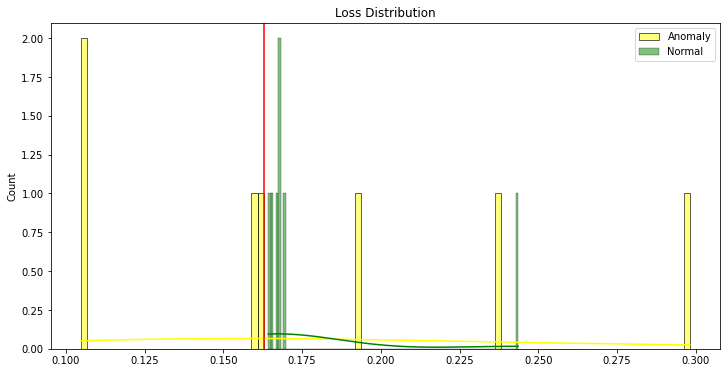

In [75]:
import seaborn as sns


lower_threshold = 0.0
upper_threshold = 0.163

plt.figure(figsize=(12,6))
plt.title('Loss Distribution')
sns.histplot(anom_list,bins=100,kde=True, label='Anomaly', color='yellow')
sns.histplot(normal_list,bins=100,kde=True, label='Normal',color='green')
plt.axvline(upper_threshold, 0.0, 10, color='r')
#plt.axvline(lower_threshold, 0.0, 10, color='b')
plt.legend()

print('Define here lower and upper threshold')


In both the above plots of the loss values, These vertical lines are an estimated threshold value for which we will determine a loss value is or is not an anomaly. In the loss distribution plot, if the value exceed (to the right) of the red line, it consider that data as an anomaly.There is a blue line that represents a lower threshold (anything below) but is not relevant for this example of data.

**Confusion matrix**

Confusion matrix where the model is re-evaluted using the previous determined threshold for MSE losses

Using this upper threshold,  make predictions on what can consider an anomaly and count the number of occurences as follows:

tp (True Positive): Both the prediction and label align for anomaly
fP (False Positive): The prediction determines anomaly but the label is non-anomalout
tn (True Negative): Both the prediction and label align for non-anomalous
fn (False Negative): The prediction determines non-anomaly but the label is anomalous

In [76]:
model.eval()
loss_dist = []

tp = 0
fp = 0
tn = 0
fn = 0

total_anom = 0

#for bx, data in enumerate(test_):
for data in test_loader:
    images, label = data
    images = images.to(device)
    outputs = model(images)
    loss = criterion(outputs, images)
    loss_dist.append(loss.item())
    # Count total number of anomalise
    total_anom += label.item()
    
    if loss>= upper_threshold:  
        if label == 1.0:
            tp += 1
        else:
            fp += 1 
    else: 
        if label == 1.0:
            fn += 1
        else:
            tn += 1 

[TP] 3	[FP] 1	[MISSED] 4
[TN] 6	[FN] 4
[ACCURACY] 0.6428571428571429


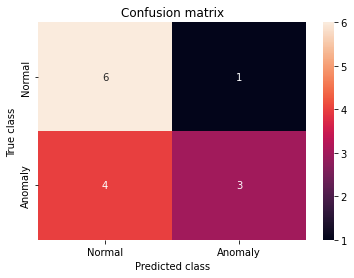

In [66]:
accuracy= (tp+tn)/(tp+tn+fp+fn)
print('[TP] {}\t[FP] {}\t[MISSED] {}'.format(tp, fp, total_anom-tp))
print('[TN] {}\t[FN] {}'.format(tn, fn))
print('[ACCURACY] {}'.format(accuracy))

conf = [[tn,fp],[fn,tp]]


plt.figure()
sns.heatmap(conf, xticklabels=['Normal','Anomaly'], yticklabels=['Normal','Anomaly'], annot=True,annot_kws={"size": 10},fmt='g')
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()


**Conclusion**

Using a traditional autoencoder built with PyTorch, from the confusion matrix I cannot identify 100% of aomalies. I received 64% accuracy for given small dataset for image with or without anomalies.

**Followimg are the improvments for future work:**

Need for Data Augmentation for small real world dataset,such as test-time augmentation.
Based on my reseach pretarined  model need large amount to dataset.
More hyper parameter tunnig on different model parameters by freezing and adding some layers.

**Transfer Learning to other types of surfaces:**

To identify anomolies in other metals such as iron, steel etc.
Fully trained model on wood dataset and it's weights can be used to identify low -level features like boundries/edges with first some layers and final layers to identify high-level features with some data augmentation, adding data and fine tunning. For example for Mask R-CNN detection model famous coco dataset trained weights are used.  

Refernces:

https://benjoe.medium.com/anomaly-detection-using-pytorch-autoencoder-and-mnist-31c5c2186329